<a href="https://colab.research.google.com/github/GuilhermeFernandez/TelecomX_2/blob/main/TelecomX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Telecom X

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import graphviz

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.datasets import load_occupancy

In [3]:
!pip freeze > requirements.txt

In [4]:
dados = pd.read_csv('dados_tratados.csv')
dados.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Contas_diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.46
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.27
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.80


In [5]:
dados = dados.drop(columns='customerID')

In [6]:
dados.dropna(inplace=True)

# 2. Visualização dos dados

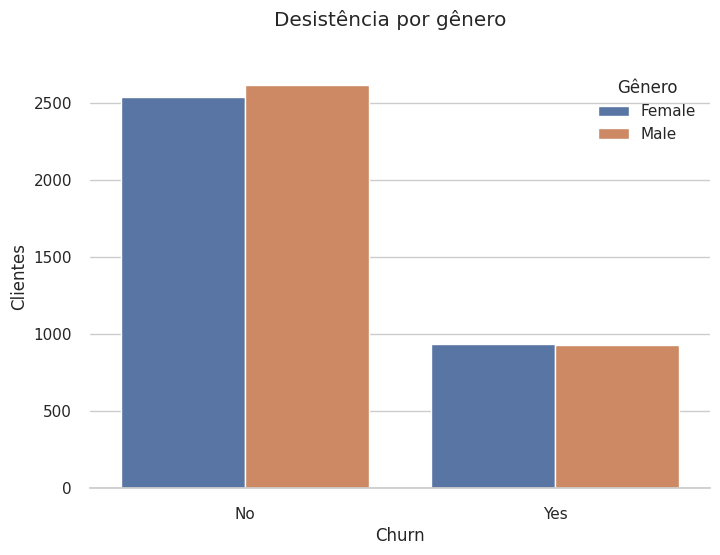

In [7]:
sns.set_theme(style="whitegrid")
p = sns.countplot(dados, x="Churn", hue="gender")
p.figure.suptitle("Desistência por gênero")
p.set_xlabel("Churn")
p.set_ylabel("Clientes")
p.legend(title="Gênero")
sns.despine(left=True, ax=p)

Text(0.5, 0.98, 'Desistência por média de gastos totais e gênero')

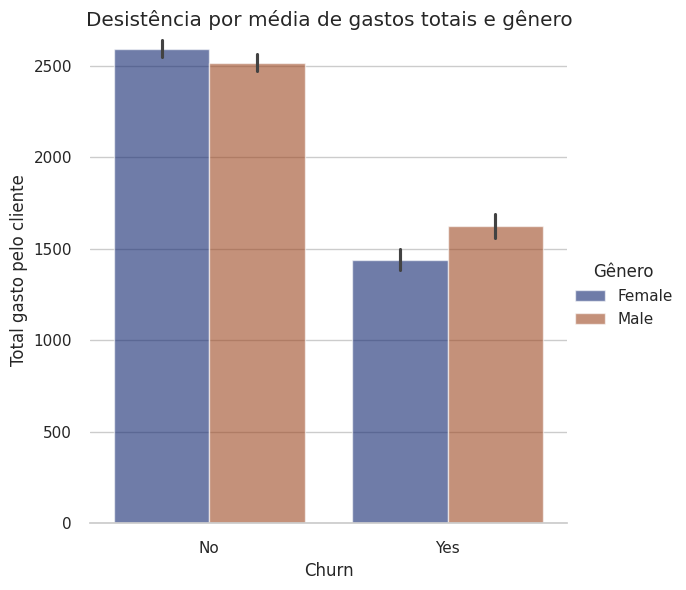

In [8]:
sns.set_theme(style="whitegrid")

p = sns.catplot(
    data=dados, kind="bar",
    x="Churn", y="Charges.Total", hue="gender",
    errorbar="se", palette="dark", alpha=.6, height=6
)
p.despine(left=True)
p.set_axis_labels("Churn", "Total gasto pelo cliente")
p.legend.set_title("Gênero")
p.fig.suptitle("Desistência por média de gastos totais e gênero")

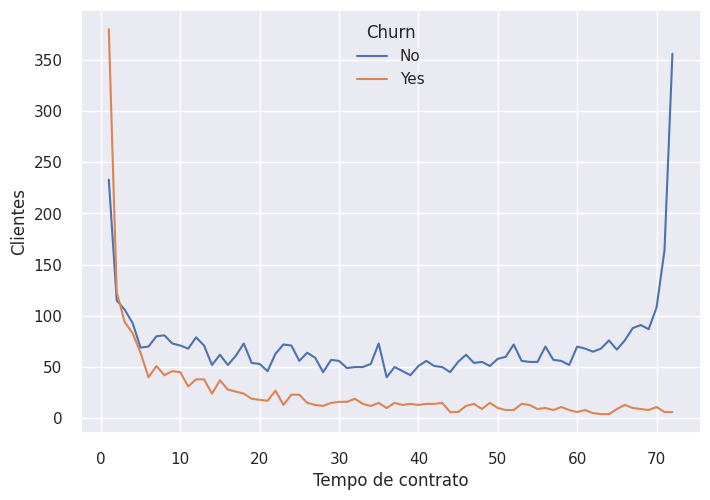

In [9]:
dados_contagem = dados.groupby(['tenure', 'Churn']).size().reset_index(name='quantidade')

sns.set_theme(style="darkgrid")
p = sns.lineplot(
    data=dados_contagem,
    x="tenure",
    y="quantidade",
    hue="Churn"
)
p.set_xlabel("Tempo de contrato")
p.set_ylabel("Clientes")
plt.show()

In [10]:
dados['Churn'] = dados['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

In [11]:
dados[['Churn', 'Charges.Monthly',	'Charges.Total',	'Contas_diarias']].corr()

,Churn,Charges.Monthly,Charges.Total,Contas_diarias
Churn,1.000000,0.192858,-0.199484,0.192914
Charges.Monthly,0.192858,1.000000,0.651065,0.999996
Charges.Total,-0.199484,0.651065,1.000000,0.651080
Contas_diarias,0.192914,0.999996,0.651080,1.000000


In [12]:
dados = dados.drop(columns='Contas_diarias')

In [13]:
x = dados.drop(columns='Churn')
y = dados['Churn']

#3. Encoding

In [14]:
colunas = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop = 'if_binary'), ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
),
    remainder = 'passthrough',
    sparse_threshold=0,
    verbose_feature_names_out=False)

In [15]:
x = one_hot.fit_transform(x)
colunas = one_hot.get_feature_names_out(colunas)
colunas

array(['gender_Male', 'SeniorCitizen_1', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automati

In [16]:
pd.DataFrame(x, columns=colunas)

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,Charges.Monthly,Charges.Total
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,65.60,593.30
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,59.90,542.40
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,73.90,280.85
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.0,98.00,1237.85
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,55.15,742.90
7028,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,22.0,85.10,1873.70
7029,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,50.30,92.75
7030,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67.0,67.85,4627.65


In [17]:
label_encoder = LabelEncoder()
y  = label_encoder.fit_transform(y)

# 4. Treino e Teste

In [18]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, random_state=2226)

# 5. Normalização

In [19]:
scaler = StandardScaler()

In [20]:
x_treino_normalizado = scaler.fit_transform(x_treino)
x_teste_normalizado = scaler.transform(x_teste)

# 6. Dummy

In [21]:
dummy = DummyClassifier(random_state=2226)

In [22]:
dummy.fit(x_treino_normalizado, y_treino)

DummyClassifier(random_state=2226)

In [23]:
dummy.score(x_teste_normalizado, y_teste)

0.7343572241183163

# 7. Árvore de Decisão

## 7.1 Fit do modelo

In [86]:
tree = DecisionTreeClassifier(random_state=2226)

In [87]:
tree.fit(x_treino, y_treino)

DecisionTreeClassifier(random_state=2226)

In [88]:
tree.score(x_teste, y_teste)

0.7275312855517634

In [89]:
tree.score(x_treino, y_treino)

0.9981039059537353

## 7.2 Visualizando importância das Features (seleção)

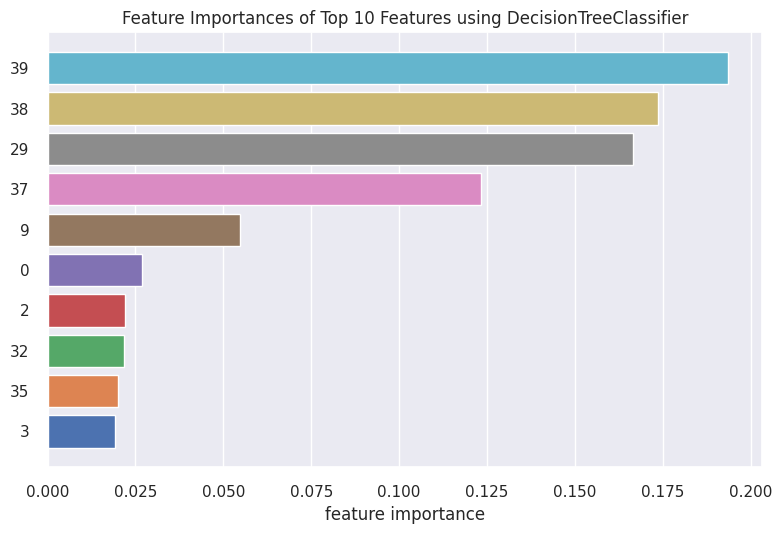

<Axes: title={'center': 'Feature Importances of Top 10 Features using DecisionTreeClassifier'}, xlabel='feature importance'>

In [90]:
viz = FeatureImportances(tree, relative=False, topn=10)
viz.fit(x_treino, y_treino)
viz.show()

In [91]:
importances = tree.feature_importances_

feature_importances = pd.DataFrame({'Features': colunas, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
39,Charges.Total,0.193628
38,Charges.Monthly,0.173705
29,Contract_Month-to-month,0.166593
37,tenure,0.123347
9,InternetService_Fiber optic,0.054782
0,gender_Male,0.026778
2,Partner_Yes,0.022083
32,PaperlessBilling_Yes,0.021726
35,PaymentMethod_Electronic check,0.019978
3,Dependents_Yes,0.019250


## 7.3 Relatório de Classificação e Seleção de variáveis

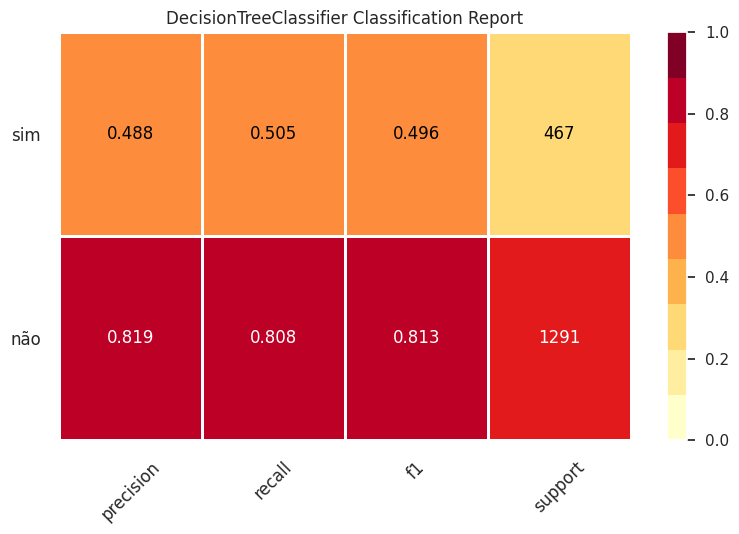

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [92]:
classes = ["não", "sim"]
visualizer = ClassificationReport(tree, classes=classes, support=True)

visualizer.fit(x_treino, y_treino)
visualizer.score(x_teste, y_teste)
visualizer.show()

precision
Precision can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

recall
Recall is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

f1 score
The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

support
Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [93]:
resultados_df = pd.DataFrame(index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim','Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'])

x_treino__df = pd.DataFrame(x_treino, columns=colunas)
x_teste__df = pd.DataFrame(x_teste, columns=colunas)

for count in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    selected_features = feature_importances['Features'].values[:count]

    x_treino_selecionado = x_treino__df[selected_features]
    x_teste_selecionado = x_teste__df[selected_features]

    tree.fit(x_treino_selecionado, y_treino)

    y_pred = tree.predict(x_teste_selecionado)

    metricas = classification_report(y_teste, y_pred, target_names=classes, output_dict=True)

    # Extrair as métricas para a classe 'sim' e 'não' (churn)
    precision_sim = metricas['sim']['precision']
    recall_sim = metricas['sim']['recall']
    f1_sim = metricas['sim']['f1-score']
    support_sim = metricas['sim']['support']
    precision_não = metricas['não']['precision']
    recall_não = metricas['não']['recall']
    f1_não = metricas['não']['f1-score']
    support_não = metricas['não']['support']

    resultados_df[count] = [precision_sim, recall_sim, f1_sim, support_sim, precision_não, recall_não, f1_não, support_não]

resultados_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,5,10,15,20,25,30,35,40,45,50
Precisão_sim,0.000000,0.250000,0.554878,0.530744,0.539519,0.496000,0.505155,0.452785,0.487603,0.487603,0.487603
Recall_sim,0.000000,0.002141,0.194861,0.351178,0.336188,0.398287,0.419700,0.400428,0.505353,0.505353,0.505353
F1-Score_sim,0.000000,0.004246,0.288431,0.422680,0.414248,0.441805,0.458480,0.425000,0.496320,0.496320,0.496320
Suporte_sim,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
Precisão_não,0.734357,0.734322,0.764115,0.790890,0.788684,0.796819,0.802190,0.791822,0.818681,0.818681,0.818681
Recall_não,1.000000,0.997676,0.943455,0.887684,0.896204,0.853602,0.851278,0.824942,0.807901,0.807901,0.807901
F1-Score_não,0.846835,0.845977,0.844367,0.836496,0.839014,0.824233,0.826005,0.808042,0.813255,0.813255,0.813255
Suporte_não,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000


In [94]:
resultados_df = pd.DataFrame(index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim','Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'])

x_treino__df = pd.DataFrame(x_treino, columns=colunas)
x_teste__df = pd.DataFrame(x_teste, columns=colunas)

for count in range(35,41):
    selected_features = feature_importances['Features'].values[:count]

    x_treino_selecionado = x_treino__df[selected_features]
    x_teste_selecionado = x_teste__df[selected_features]

    tree.fit(x_treino_selecionado, y_treino)

    y_pred = tree.predict(x_teste_selecionado)

    metricas = classification_report(y_teste, y_pred, target_names=classes, output_dict=True)

    # Extrair as métricas para a classe 'sim' e 'não' (churn)
    precision_sim = metricas['sim']['precision']
    recall_sim = metricas['sim']['recall']
    f1_sim = metricas['sim']['f1-score']
    support_sim = metricas['sim']['support']
    precision_não = metricas['não']['precision']
    recall_não = metricas['não']['recall']
    f1_não = metricas['não']['f1-score']
    support_não = metricas['não']['support']

    resultados_df[count] = [precision_sim, recall_sim, f1_sim, support_sim, precision_não, recall_não, f1_não, support_não]

resultados_df

,35,36,37,38,39,40
Precisão_sim,0.452785,0.446429,0.442130,0.507726,0.488223,0.487603
Recall_sim,0.400428,0.428266,0.408994,0.492505,0.488223,0.505353
F1-Score_sim,0.425000,0.437158,0.424917,0.500000,0.488223,0.496320
Suporte_sim,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
Precisão_não,0.791822,0.796183,0.791855,0.818391,0.814872,0.818681
Recall_não,0.824942,0.807901,0.813323,0.827266,0.814872,0.807901
F1-Score_não,0.808042,0.801999,0.802446,0.822804,0.814872,0.813255
Suporte_não,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000


In [95]:
feature_selecionada = feature_importances['Features'].values[:38]

x_df = pd.DataFrame(x, columns=colunas)
x_feature_selecionada = x_df[feature_selecionada]

## 7.4 Realizando nova modelagem

In [96]:
x_treino_dt, x_teste_dt, y_treino_dt, y_teste_dt = train_test_split(x_feature_selecionada, y, stratify=y, random_state=2226)

In [97]:
tree.fit(x_treino_dt, y_treino_dt)

DecisionTreeClassifier(random_state=2226)

In [98]:
tree.score(x_teste_dt, y_teste_dt)

0.7383390216154722

In [99]:
tree.score(x_treino_dt, y_treino_dt)

0.981039059537353

Valores subiram marginalmente, mas provavelmente ganhou performance (diminuiu colunas desnecessárias)

## 7.5 Otimizando os parâmetros

In [100]:
param_grid = {
      'max_depth': [3, 5, 7, 9, 11],
      'min_samples_leaf': [1, 2, 3],
      'min_samples_split': [2, 3],
      'random_state': [2226]
 }

In [101]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2226)

model_grid = GridSearchCV(DecisionTreeClassifier(random_state=2226), param_grid=param_grid,
             scoring='f1', cv=cv)

model_grid.fit(x_treino_dt, y_treino_dt)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2226, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=2226),
             param_grid={'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3], 'random_state': [2226]},
             scoring='f1')

In [102]:
model_grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 2226}

##7.6 Avaliação Final

In [103]:
y_pred_dt = model_grid.best_estimator_.predict(x_teste_dt)
metricas = classification_report(y_teste, y_pred_dt, target_names=classes, output_dict=True)

precision_sim = metricas['sim']['precision']
recall_sim = metricas['sim']['recall']
f1_sim = metricas['sim']['f1-score']
support_sim = metricas['sim']['support']
precision_não = metricas['não']['precision']
recall_não = metricas['não']['recall']
f1_não = metricas['não']['f1-score']
support_não = metricas['não']['support']
resultados_final = [
    precision_sim, recall_sim, f1_sim, support_sim,
    precision_não, recall_não, f1_não, support_não
]

resultados_final_df = pd.DataFrame(
    resultados_final,
    index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim',
           'Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'],
    columns=['Métricas do Modelo Otimizado']
)

resultados_final_df

,Métricas do Modelo Otimizado
Precisão_sim,0.588235
Recall_sim,0.578158
F1-Score_sim,0.583153
Suporte_sim,467.000000
Precisão_não,0.848345
Recall_não,0.853602
F1-Score_não,0.850965
Suporte_não,1291.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


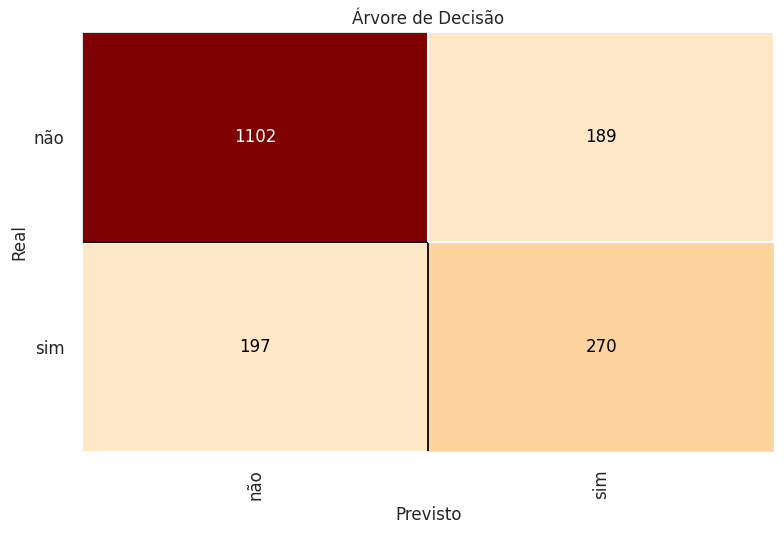

In [104]:
viz = ConfusionMatrix(model_grid.best_estimator_, classes=classes, support=True, cmap='OrRd')
viz.fit(x_treino_dt, y_treino)
viz.score(x_teste_dt, y_teste)

viz.finalize()

viz.ax.set_xlabel('Previsto')
viz.ax.set_ylabel('Real')
viz.ax.set_title('Árvore de Decisão')

plt.savefig('matriz_confusao_DT.png', bbox_inches='tight', dpi=600)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


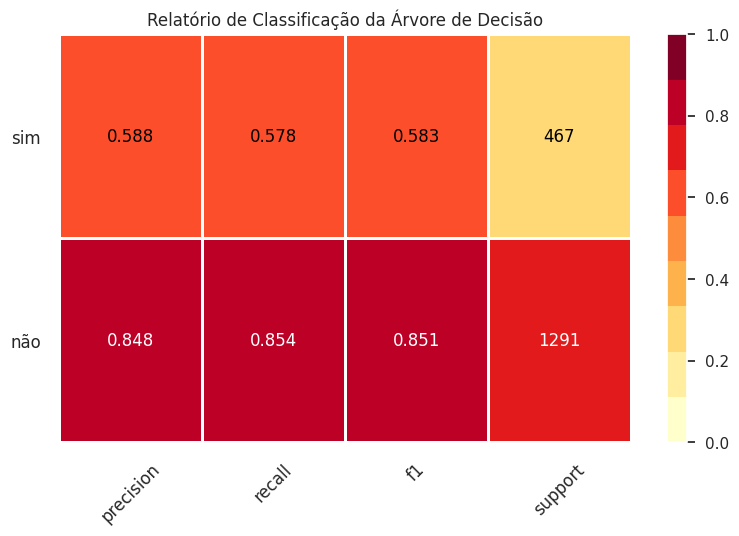

In [105]:
visualizer = ClassificationReport(model_grid.best_estimator_, classes=classes, support=True)

visualizer.fit(x_treino_dt, y_treino)
visualizer.score(x_teste_dt, y_teste)
visualizer.finalize()
visualizer.ax.set_title('Relatório de Classificação da Árvore de Decisão')

plt.savefig('relatorio_DT.png', bbox_inches='tight', dpi=600)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


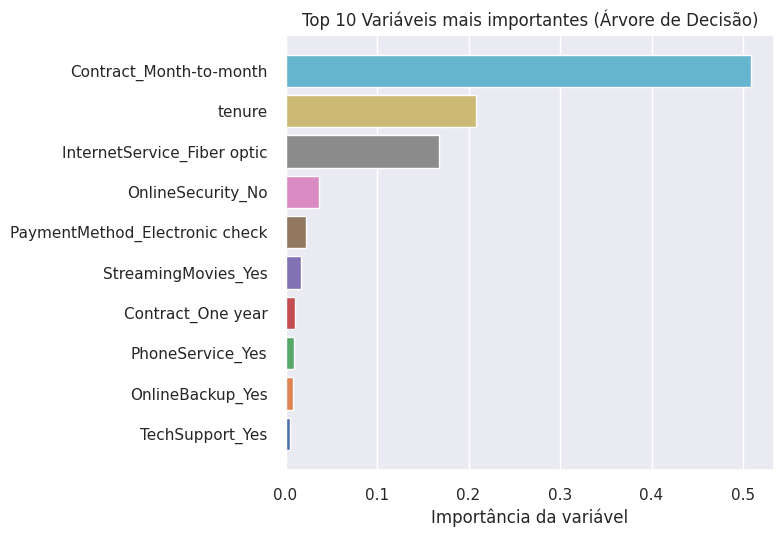

In [106]:
viz = FeatureImportances(model_grid.best_estimator_, relative=False, topn=10)
viz.fit(x_treino_dt, y_treino_dt)
viz.finalize()
viz.ax.set_title('Top 10 Variáveis mais importantes (Árvore de Decisão)')
viz.ax.set_xlabel('Importância da variável')

plt.savefig('variaveis_DT.png', bbox_inches='tight', dpi=600)
plt.show()

In [107]:
importances = model_grid.best_estimator_.feature_importances_

feature_importances = pd.DataFrame({'Features': feature_selecionada, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
29,Contract_Month-to-month,0.508464
37,tenure,0.208519
9,InternetService_Fiber optic,0.167203
11,OnlineSecurity_No,0.036728
35,PaymentMethod_Electronic check,0.021978
28,StreamingMovies_Yes,0.016725
30,Contract_One year,0.010525
4,PhoneService_Yes,0.008898
16,OnlineBackup_Yes,0.008396
22,TechSupport_Yes,0.005124


## 7.7 Árvore de Decisão

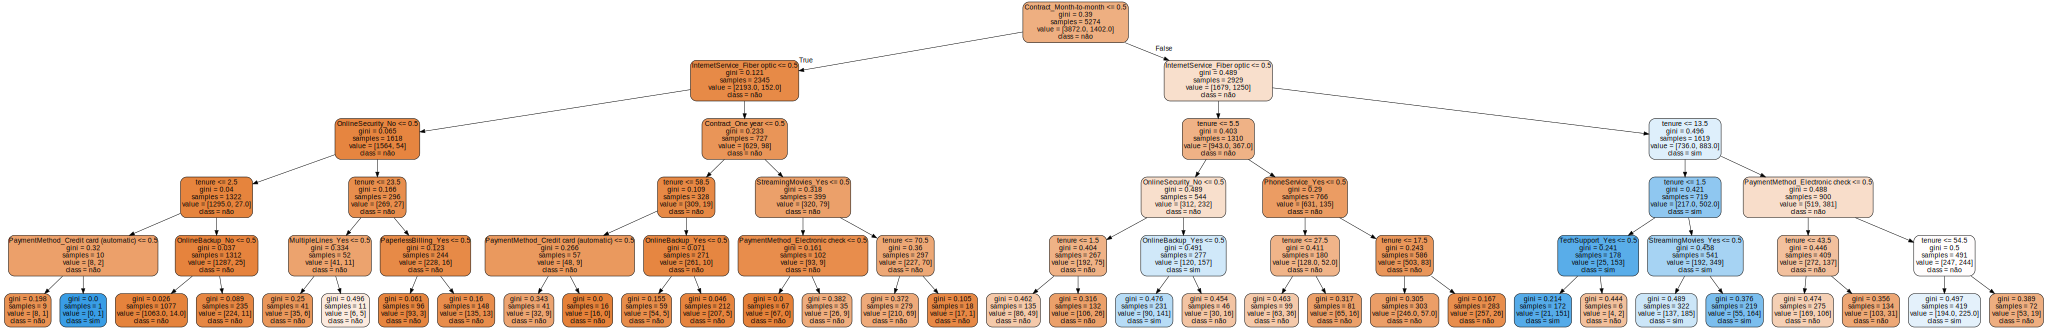

In [108]:
estrutura = export_graphviz(model_grid.best_estimator_, filled=True, class_names= ['não', 'sim'], feature_names=colunas[:38], rounded=True)
grafico = graphviz.Source(estrutura)

grafico.render(filename="arvore_de_decisao", format="png", cleanup=True)

grafico

##7.8 Exportação Modelo Decision Tree

In [109]:
try:
  with open('model_churn_dt.pkl', 'wb') as file:
    pickle.dump(model_grid.best_estimator_, file)
  print('Modelo salvo com sucesso!!!')
except Exception as e:
  print('Ocorreu um erro ao salvar o modelo: ', str(e))

Modelo salvo com sucesso!!!


# 8. KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
knn = KNeighborsClassifier()

In [50]:
knn.fit(x_treino_normalizado, y_treino)

KNeighborsClassifier()

In [51]:
knn.score(x_teste_normalizado, y_teste)

0.7491467576791809

In [52]:
knn.score(x_treino_normalizado, y_treino)

0.8376943496397421

## 8.1 Visualizando importância das Features

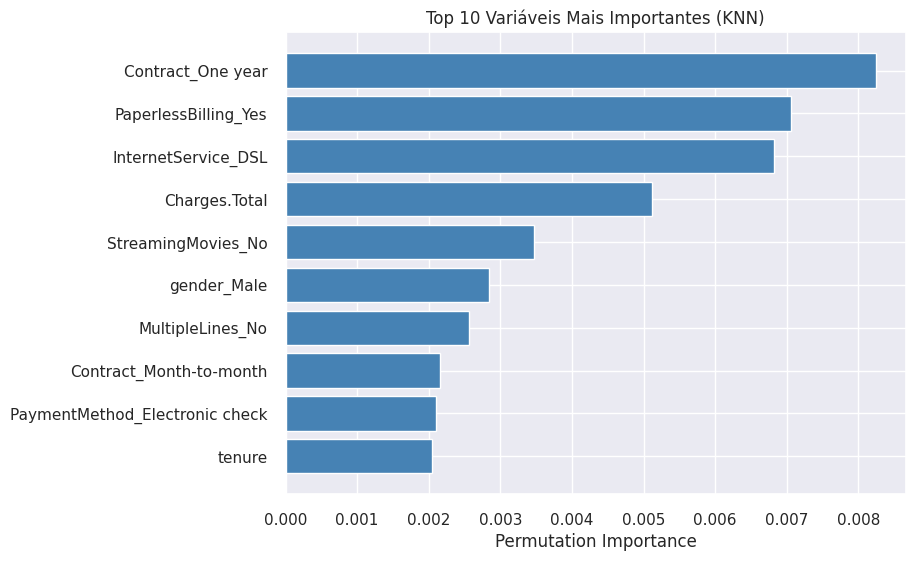

In [53]:
# Calculate permutation importance
result = permutation_importance(knn, x_teste_normalizado, y_teste, n_repeats=10, random_state=2226)

importancias_series = pd.Series(result.importances_mean, index=colunas)
top_10 = importancias_series.sort_values(ascending=False).head(10)
top_10 = top_10.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_10.index, top_10.values, color='steelblue')
plt.xlabel('Permutation Importance')
plt.title('Top 10 Variáveis Mais Importantes (KNN)')
plt.show()

## 8.2 Relatório de Classificação e Seleção de variáveis

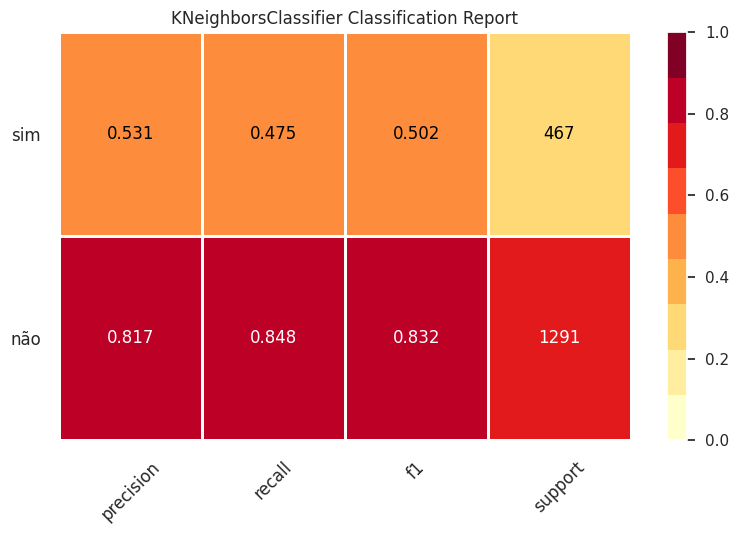

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [54]:
classes = ["não", "sim"]
visualizer = ClassificationReport(knn, classes=classes, support=True)

visualizer.fit(x_treino_normalizado, y_treino)        # Fit the visualizer and the model
visualizer.score(x_teste_normalizado, y_teste)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

## 8.3 Otimizando os parâmetros

In [55]:
param_grid = {
      'n_neighbors': [5, 7, 9,10],
      'weights': ['uniform', 'distance']
 }

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [57]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2226)

model_grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid,
             scoring='f1', cv=cv)

model_grid.fit(x_treino_normalizado, y_treino)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2226, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [58]:
model_grid.best_params_

{'n_neighbors': 9, 'weights': 'uniform'}

## 8.5 Avaliação Final

In [59]:
y_pred_knn = model_grid.best_estimator_.predict(x_teste_normalizado)
metricas = classification_report(y_teste, y_pred_knn, target_names=classes, output_dict=True)

precision_sim = metricas['sim']['precision']
recall_sim = metricas['sim']['recall']
f1_sim = metricas['sim']['f1-score']
support_sim = metricas['sim']['support']
precision_não = metricas['não']['precision']
recall_não = metricas['não']['recall']
f1_não = metricas['não']['f1-score']
support_não = metricas['não']['support']
resultados_final = [
    precision_sim, recall_sim, f1_sim, support_sim,
    precision_não, recall_não, f1_não, support_não
]

resultados_final_df = pd.DataFrame(
    resultados_final,
    index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim',
           'Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'],
    columns=['Métricas do Modelo Otimizado']
)

print(resultados_final_df)

              Métricas do Modelo Otimizado
Precisão_sim                      0.549261
Recall_sim                        0.477516
F1-Score_sim                      0.510882
Suporte_sim                     467.000000
Precisão_não                      0.819527
Recall_não                        0.858249
F1-Score_não                      0.838441
Suporte_não                    1291.000000


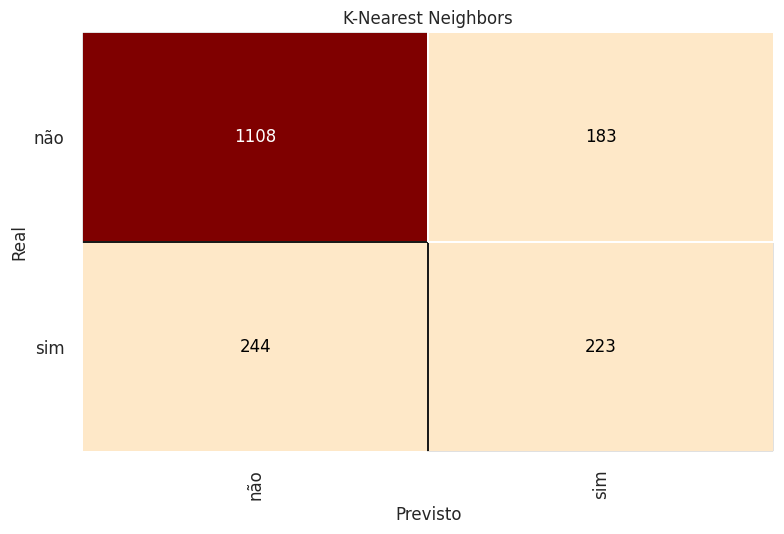

In [60]:
viz = ConfusionMatrix(model_grid.best_estimator_, classes=classes, support=True, cmap='OrRd')
viz.fit(x_treino_normalizado, y_treino)
viz.score(x_teste_normalizado, y_teste)

viz.finalize()

viz.ax.set_xlabel('Previsto')
viz.ax.set_ylabel('Real')
viz.ax.set_title('K-Nearest Neighbors')

plt.savefig('matriz_confusao_KNN.png', bbox_inches='tight', dpi=600)
plt.show()



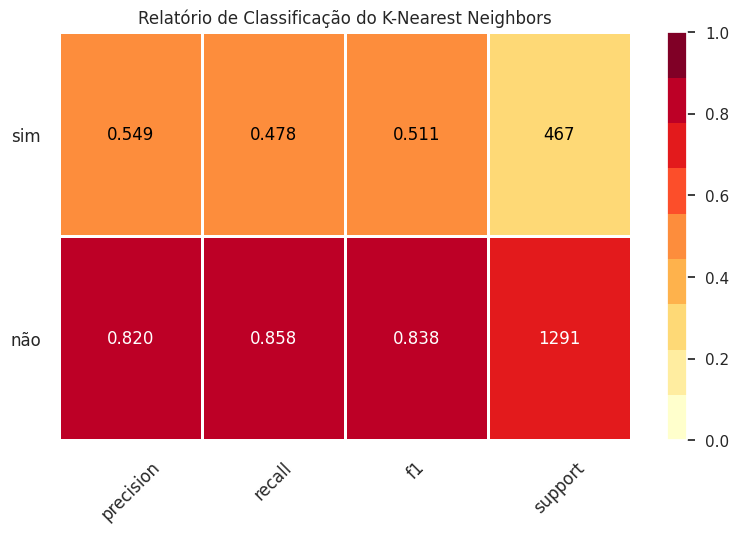

In [61]:
visualizer = ClassificationReport(model_grid.best_estimator_, classes=classes, support=True)

visualizer.fit(x_treino_normalizado, y_treino)
visualizer.score(x_teste_normalizado, y_teste)

visualizer.finalize()
visualizer.ax.set_title('Relatório de Classificação do K-Nearest Neighbors')

plt.savefig('relatorio_KNN.png', bbox_inches='tight', dpi=600)
plt.show()

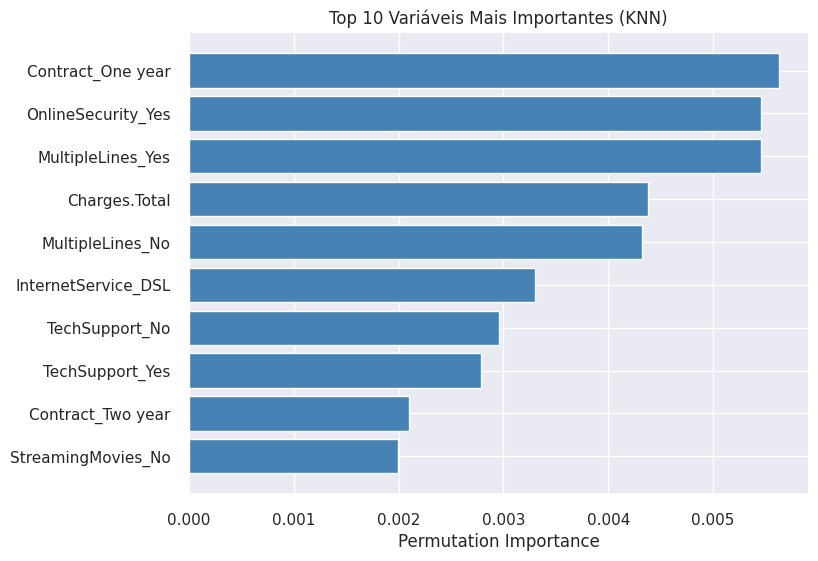

In [62]:
# Calculate permutation importance
result = permutation_importance(model_grid.best_estimator_, x_teste_normalizado, y_teste, n_repeats=10, random_state=2226)

importancias_series = pd.Series(result.importances_mean, index=colunas)
top_10 = importancias_series.sort_values(ascending=False).head(10)
top_10 = top_10.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_10.index, top_10.values, color='steelblue')
plt.xlabel('Permutation Importance')
plt.title('Top 10 Variáveis Mais Importantes (KNN)')
plt.savefig('variaveis_KNN.png', bbox_inches='tight', dpi=600)
plt.show()

## 8.6 Exportando Modelo KNN

In [63]:
try:
  with open('model_churn_knn.pkl', 'wb') as file:
    pickle.dump(model_grid.best_estimator_, file)
  print('Modelo salvo com sucesso!!!')
except Exception as e:
  print('Ocorreu um erro ao salvar o modelo: ', str(e))

Modelo salvo com sucesso!!!


#9. Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
random_forest = RandomForestClassifier(random_state=2226)

In [112]:
random_forest.fit(x_treino, y_treino)

RandomForestClassifier(random_state=2226)

In [113]:
random_forest.score(x_teste, y_teste)

0.7866894197952219

In [114]:
random_forest.score(x_treino, y_treino)

0.9981039059537353

## 9.2 Visualizando importância das Features (seleção)

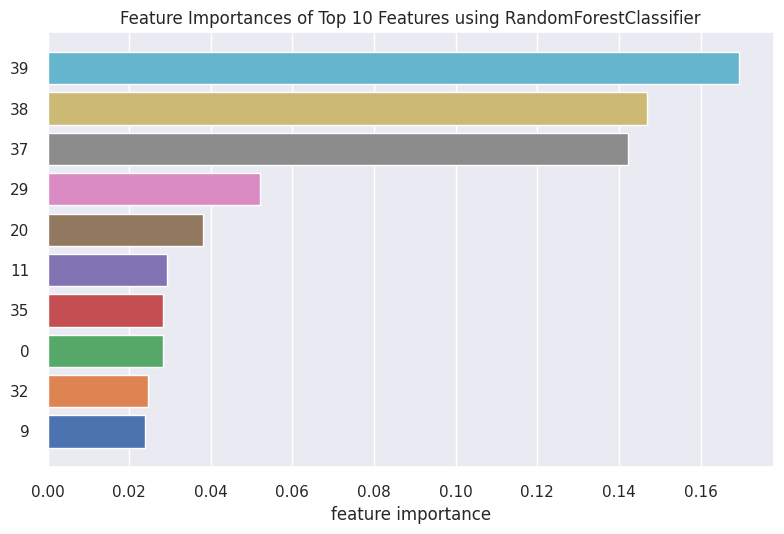

<Axes: title={'center': 'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [115]:
viz = FeatureImportances(random_forest, relative=False, topn=10)
viz.fit(x_treino, y_treino)
viz.show()

In [116]:
importances = random_forest.feature_importances_

feature_importances = pd.DataFrame({'Features': colunas, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
39,Charges.Total,0.169522
38,Charges.Monthly,0.146773
37,tenure,0.142250
29,Contract_Month-to-month,0.052080
20,TechSupport_No,0.038046
11,OnlineSecurity_No,0.029225
35,PaymentMethod_Electronic check,0.028337
0,gender_Male,0.028218
32,PaperlessBilling_Yes,0.024706
9,InternetService_Fiber optic,0.023787


## 9.3 Relatório de Classificação e Seleção de variáveis

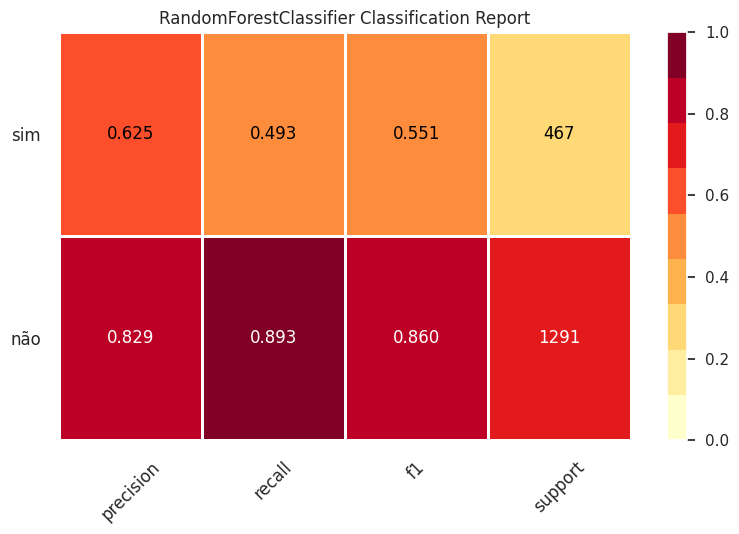

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [117]:
classes = ["não", "sim"]
visualizer = ClassificationReport(random_forest, classes=classes, support=True)

visualizer.fit(x_treino, y_treino)
visualizer.score(x_teste, y_teste)
visualizer.show()

In [118]:
resultados_df = pd.DataFrame(index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim','Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'])

x_treino__df = pd.DataFrame(x_treino, columns=colunas)
x_teste__df = pd.DataFrame(x_teste, columns=colunas)

for count in [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    selected_features = feature_importances['Features'].values[:count]

    x_treino_selecionado = x_treino__df[selected_features]
    x_teste_selecionado = x_teste__df[selected_features]

    random_forest.fit(x_treino_selecionado, y_treino)

    y_pred = random_forest.predict(x_teste_selecionado)

    metricas = classification_report(y_teste, y_pred, target_names=classes, output_dict=True)

    # Extrair as métricas para a classe 'sim' e 'não' (churn)
    precision_sim = metricas['sim']['precision']
    recall_sim = metricas['sim']['recall']
    f1_sim = metricas['sim']['f1-score']
    support_sim = metricas['sim']['support']
    precision_não = metricas['não']['precision']
    recall_não = metricas['não']['recall']
    f1_não = metricas['não']['f1-score']
    support_não = metricas['não']['support']

    resultados_df[count] = [precision_sim, recall_sim, f1_sim, support_sim, precision_não, recall_não, f1_não, support_não]

resultados_df

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,1,5,10,15,20,25,30,35,40,45,50
Precisão_sim,0.000000,0.250000,0.548193,0.532051,0.543689,0.492424,0.526582,0.529114,0.625000,0.625000,0.625000
Recall_sim,0.000000,0.002141,0.194861,0.355460,0.359743,0.417559,0.445396,0.447537,0.492505,0.492505,0.492505
F1-Score_sim,0.000000,0.004246,0.287520,0.426187,0.432990,0.451912,0.482599,0.484919,0.550898,0.550898,0.550898
Suporte_sim,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
Precisão_não,0.734357,0.734322,0.763819,0.791840,0.793651,0.800294,0.809978,0.810712,0.829496,0.829496,0.829496
Recall_não,1.000000,0.997676,0.941905,0.886909,0.890782,0.844307,0.855151,0.855926,0.893106,0.893106,0.893106
F1-Score_não,0.846835,0.845977,0.843566,0.836682,0.839416,0.821711,0.831952,0.832705,0.860127,0.860127,0.860127
Suporte_não,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000


In [119]:
resultados_df = pd.DataFrame(index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim','Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'])

x_treino__df = pd.DataFrame(x_treino, columns=colunas)
x_teste__df = pd.DataFrame(x_teste, columns=colunas)

for count in range(35,41):
    selected_features = feature_importances['Features'].values[:count]

    x_treino_selecionado = x_treino__df[selected_features]
    x_teste_selecionado = x_teste__df[selected_features]

    random_forest.fit(x_treino_selecionado, y_treino)

    y_pred = random_forest.predict(x_teste_selecionado)

    metricas = classification_report(y_teste, y_pred, target_names=classes, output_dict=True)

    # Extrair as métricas para a classe 'sim' e 'não' (churn)
    precision_sim = metricas['sim']['precision']
    recall_sim = metricas['sim']['recall']
    f1_sim = metricas['sim']['f1-score']
    support_sim = metricas['sim']['support']
    precision_não = metricas['não']['precision']
    recall_não = metricas['não']['recall']
    f1_não = metricas['não']['f1-score']
    support_não = metricas['não']['support']

    resultados_df[count] = [precision_sim, recall_sim, f1_sim, support_sim, precision_não, recall_não, f1_não, support_não]

resultados_df

,35,36,37,38,39,40
Precisão_sim,0.529114,0.528061,0.537468,0.593496,0.607895,0.625000
Recall_sim,0.447537,0.443255,0.445396,0.468951,0.494647,0.492505
F1-Score_sim,0.484919,0.481956,0.487119,0.523923,0.545455,0.550898
Suporte_sim,467.000000,467.000000,467.000000,467.000000,467.000000,467.000000
Precisão_não,0.810712,0.809663,0.811087,0.821454,0.828737,0.829496
Recall_não,0.855926,0.856700,0.861348,0.883811,0.884586,0.893106
F1-Score_não,0.832705,0.832518,0.835462,0.851493,0.855751,0.860127
Suporte_não,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000


In [120]:
feature_selecionada = feature_importances['Features'].values[:40]

x_df = pd.DataFrame(x, columns=colunas)
x_feature_selecionada = x_df[feature_selecionada]

## 9.4 Realizando nova modelagem

In [121]:
x_treino_rf, x_teste_rf, y_treino_rf, y_teste_rf = train_test_split(x_feature_selecionada, y, stratify=y, random_state=2226)

In [122]:
random_forest.fit(x_treino_rf, y_treino_rf)

RandomForestClassifier(random_state=2226)

In [123]:
random_forest.score(x_teste_rf, y_teste_rf)

0.7866894197952219

In [124]:
random_forest.score(x_treino_rf, y_treino_rf)

0.9981039059537353

Valores subiram marginalmente, mas provavelmente ganhou performance (diminuiu colunas desnecessárias)

## 9.5 Otimizando os parâmetros

In [125]:
param_grid = {
      'n_estimators': [10, 30, 50, 70, 100],
      'min_samples_leaf': [1, 2, 3],
      'max_depth': [2, 3, 4, 5],
      'min_samples_split': [2, 3],
      'random_state': [2226]
 }

In [126]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2226)

model_grid = GridSearchCV(RandomForestClassifier(random_state=2226), param_grid=param_grid,
             scoring='f1', cv=cv)

model_grid.fit(x_treino_rf, y_treino_rf)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2226, shuffle=True),
             estimator=RandomForestClassifier(random_state=2226),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [10, 30, 50, 70, 100],
                         'random_state': [2226]},
             scoring='f1')

In [127]:
model_grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 10,
 'random_state': 2226}

##9.6 Avaliação Final

In [129]:
y_pred_rf = model_grid.best_estimator_.predict(x_teste_rf)
metricas = classification_report(y_teste, y_pred_rf, target_names=classes, output_dict=True)

precision_sim = metricas['sim']['precision']
recall_sim = metricas['sim']['recall']
f1_sim = metricas['sim']['f1-score']
support_sim = metricas['sim']['support']
precision_não = metricas['não']['precision']
recall_não = metricas['não']['recall']
f1_não = metricas['não']['f1-score']
support_não = metricas['não']['support']
resultados_final = [
    precision_sim, recall_sim, f1_sim, support_sim,
    precision_não, recall_não, f1_não, support_não
]

resultados_final_df = pd.DataFrame(
    resultados_final,
    index=['Precisão_sim', 'Recall_sim', 'F1-Score_sim', 'Suporte_sim',
           'Precisão_não', 'Recall_não', 'F1-Score_não', 'Suporte_não'],
    columns=['Métricas do Modelo Otimizado']
)

resultados_final_df

,Métricas do Modelo Otimizado
Precisão_sim,0.668810
Recall_sim,0.445396
F1-Score_sim,0.534704
Suporte_sim,467.000000
Precisão_não,0.821009
Recall_não,0.920217
F1-Score_não,0.867787
Suporte_não,1291.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


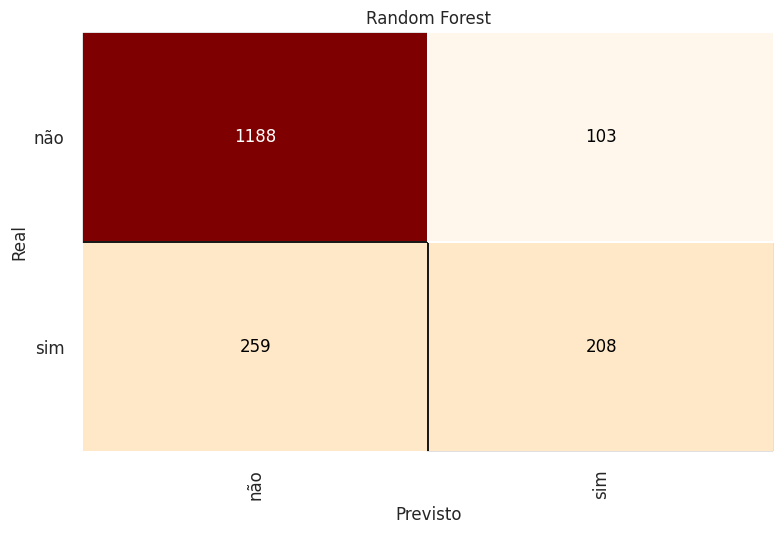

In [131]:
viz = ConfusionMatrix(model_grid.best_estimator_, classes=classes, support=True, cmap='OrRd')
viz.fit(x_treino_rf, y_treino)
viz.score(x_teste_rf, y_teste)

viz.finalize()

viz.ax.set_xlabel('Previsto')
viz.ax.set_ylabel('Real')
viz.ax.set_title('Random Forest')

plt.savefig('matriz_confusao_RF.png', bbox_inches='tight', dpi=600)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


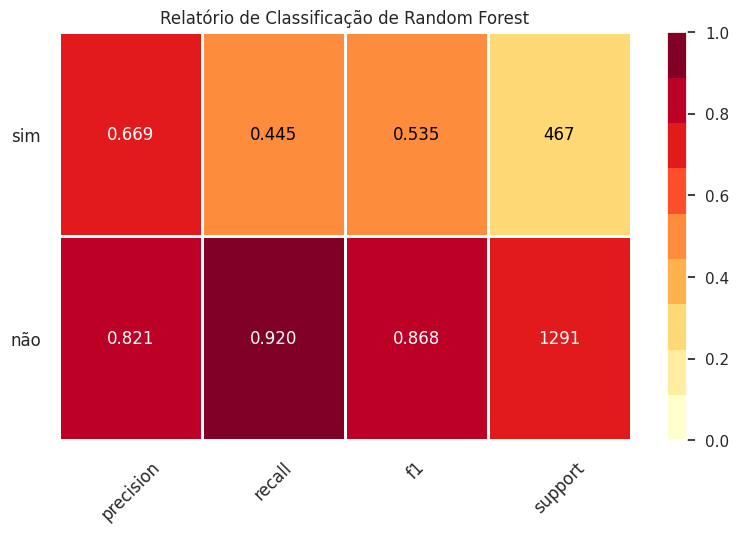

In [132]:
visualizer = ClassificationReport(model_grid.best_estimator_, classes=classes, support=True)

visualizer.fit(x_treino_rf, y_treino)
visualizer.score(x_teste_rf, y_teste)
visualizer.finalize()
visualizer.ax.set_title('Relatório de Classificação de Random Forest')

plt.savefig('relatorio_RF.png', bbox_inches='tight', dpi=600)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


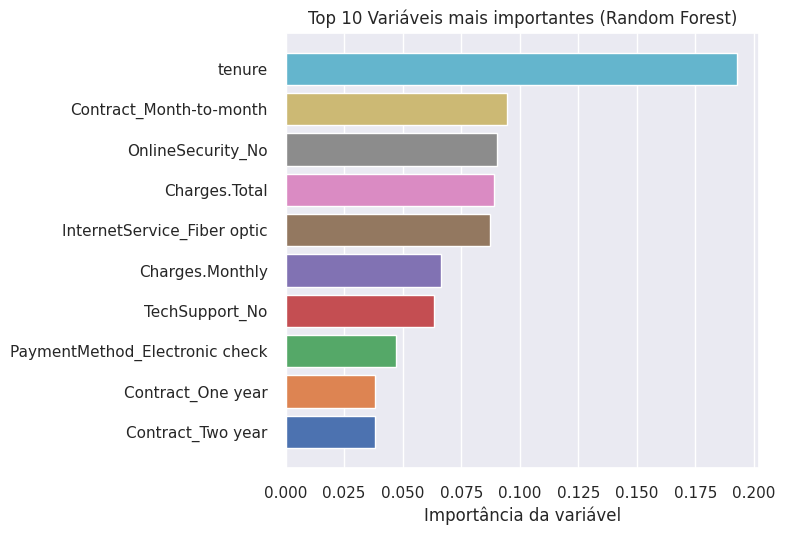

In [133]:
viz = FeatureImportances(model_grid.best_estimator_, relative=False, topn=10)
viz.fit(x_treino_rf, y_treino_rf)
viz.finalize()
viz.ax.set_title('Top 10 Variáveis mais importantes (Random Forest)')
viz.ax.set_xlabel('Importância da variável')

plt.savefig('variaveis_RF.png', bbox_inches='tight', dpi=600)
plt.show()

In [134]:
importances = model_grid.best_estimator_.feature_importances_

feature_importances = pd.DataFrame({'Features': feature_selecionada, 'Importances': importances})
feature_importances.sort_values('Importances', ascending=False)

,Features,Importances
37,tenure,0.192638
29,Contract_Month-to-month,0.094577
11,OnlineSecurity_No,0.090260
39,Charges.Total,0.088819
9,InternetService_Fiber optic,0.087129
38,Charges.Monthly,0.066320
20,TechSupport_No,0.063481
35,PaymentMethod_Electronic check,0.046948
30,Contract_One year,0.038404
31,Contract_Two year,0.038137


## 9.7 Árvore de Decisão

In [139]:
estimator = model_grid.best_estimator_.estimators_[5]

dot_data = export_graphviz(
    estimator,
    out_file=None,
    class_names= ['não', 'sim'],
    feature_names=colunas[:40],
    filled=True,
    rounded=True,
    precision=2,
    special_characters=True
)

graph = graphviz.Source(dot_data, format="png")
graph.view()

'Source.gv.png'

##9.8 Exportação Modelo Random Forest

In [140]:
try:
  with open('model_rf.pkl', 'wb') as file:
    pickle.dump(model_grid.best_estimator_, file)
  print('Modelo salvo com sucesso!!!')
except Exception as e:
  print('Ocorreu um erro ao salvar o modelo: ', str(e))

Modelo salvo com sucesso!!!


# 9. Relatório Final

Esse projeto teve como objetivo a construção de modelos capazes de prever a evasão (churn) de clientes da empresa Telecom X. Para tanto, foram realizadas visualizações gráficas para uma abordagem inicial do tema.

Os modelos selecionados foram:

**Árvore de Decisão (Decision Tree Classifier)**

A escolha da Árvore de Decisão é justificada por sua alta interpretabilidade e capacidade de lidar com relações não lineares. Em problemas de negócios como o estudado, é fundamental não apenas prever quem vai cancelar, mas entender os motivos. A árvore cria regras lógicas que podem ser vistas no item 7.7 (Contrato mês-a-mês é verdadeiro ou falso? O tempo de contrato é maior ou menor que 14 meses?, etc), o que facilita a explicação técnica para partes interessadas e a formulação de estratégias de retenção.

**K-Nearest Neighbors (KNN)**

O KNN foi selecionado pela sua abordagem baseada em instâncias (similaridade). A premissa é classificar um cliente com base no comportamento de clientes passados que possuem perfis semelhantes.

Diferente da Árvore de Decisão, o algoritmo KNN é estritamente dependente do cálculo de distâncias matemáticas entre os pontos de dados. Variáveis com escalas financeiras (como `Charges.Total`, que pode chegar a milhares) dominariam completamente o cálculo de distância sobre variáveis de escala menor (como `tenure` em meses, ou variáveis categóricas transformadas em 0 e 1). A normalização (feita com o método `StandardScaler`) coloca todas as variáveis na mesma escala, garantindo que o algoritmo avalie a proximidade dos "vizinhos" considerando o peso real de cada característica, sem distorções numéricas.

---
O modelo de **Árvore de Decisão Otimizada** apresentou um desempenho robusto e equilibrado após a validação cruzada (`GridSearchCV`). Ao focar na métrica *F1-Score* o modelo saltou de um *Recall* inicial quase nulo para **0.578**, mantendo uma excelente performance na classe majoritária (F1-Score de **0.851** para "não", Precisão de ~85%).

![Relatório_DT](https://github.com/GuilhermeFernandez/TelecomX_2/blob/main/relatorio_DT.png?raw=true)

A capacidade do modelo de identificar corretamente quase 60% dos clientes prestes a cancelar, sem gerar um volume excessivo de Falsos Positivos, torna-o uma ferramenta altamente viável para campanhas direcionadas de retenção.

---
Já o modelo **K-Nearest Neighbors** apresentou um desempenho alto de início, mas que não apresentou muita melhora após a validação cruzada e o aprimoramento dos parâmetros (em precisão, a Árvore de Decisão aumentou em 3 pontos percentuais, enquanto KNN apenas 0.3%).

![Relatório_KNN](https://github.com/GuilhermeFernandez/TelecomX_2/blob/main/relatorio_KNN.png?raw=true)

---
Durante as iterações de modelagem, observou-se um cenário inicial de viés provocado por Overfitting somado ao desbalanceamento de classes na Árvore de Decisão e em KNN, resultando em um modelo com alta previsão para os dados de treino (~99%). Esse Overfitting pode ser observado também na importância inicial das variáveis, nas quais o modelo de Árvore de Decisão deu muita importância para variáveis que tinha grande diversidade entre os clientes, provavelmente decorando ao invés de aprender. Isso mudou posteriormente.

Para correção disso, foram utilizados algumas metodologias:
*Stratify*: foi realizada a estratificação dos dados de treinamento e teste, de modo a ter % representativa de ambas as classes de y nos dois datasets;

*Feature Importance*: foi verificado o número ideal de features para os modelos, de modo a melhorar sua performance e reduzir dados que poderiam estar gerando confusão e não melhorando o desempenho;

*GridSearchCV*: por último foi realizada a validação cruzada e a testagem cruzada de hiperparâmetros para aprimorar o modelo, chegando aos resultados finais.

---
A visualização completa da Árvore de Decisão revelou uma estrutura profunda e complexa. No entanto, ao extrair a importância das variáveis, percebemos que o modelo concentra sua decisão de forma esmagadora em apenas três fatores principais:

Contract_Month-to-month (Contrato Mensal): É, de longe, o atributo mais decisivo (peso superior a 0.5). Isso indica que esse tipo de contrato é o maior divisor de águas para prever o comportamento do cliente neste modelo.

tenure (Tempo de permanência): O segundo fator mais importante, indicando que a fidelidade histórica do cliente pesa muito na probabilidade de churn.

InternetService_Fiber optic (Internet Fibra Ótica): O tipo de serviço de internet também se mostrou crucial para os cortes e regras (splits) gerados pela árvore.

![Variáveis_DT](https://github.com/GuilhermeFernandez/TelecomX_2/blob/main/variaveis_DT.png?raw=true)

Ou seja, campanhas para adesão de cheque eletrônico são extremamente necessárias, bem como ofertas para que os clientes adquiram outros produtos, aumentando fidelidade.


Já o KNN não possui um atributo nativo de "importância de variáveis". Para contornar isso, utilizei a técnica de **Permutation Importance** (Importância por Permutação) com base nesse post do [Github](https://github.com/scikit-learn/scikit-learn/discussions/28304).

Diferente da Árvore de Decisão, o modelo KNN apresentou uma distribuição de importância muito mais equilibrada. Nenhuma variável domina a decisão sozinha.

Os fatores que mais influenciaram a proximidade entre clientes com comportamentos semelhantes foram:

Contract_One year (Contrato de 1 ano): O tipo de contrato continua sendo vital, mas o modelo olhou mais para a estabilidade do contrato anual.

Serviços Adicionais: Variáveis como OnlineSecurity_Yes, MultipleLines_Yes e TechSupport_No ganharam bastante destaque, mostrando que o pacote de serviços contratado molda "agrupamentos" de clientes no espaço multidimensional do KNN.

Charges.Total (Cobrança Total): O valor gasto também foi um fator de grande relevância para aproximar ou afastar perfis no modelo.

![variaveis_KNN](https://github.com/GuilhermeFernandez/TelecomX_2/blob/main/variaveis_KNN%20(1).png?raw=true)

---
#Conclusão
Ambos os modelos consideram cruciais as informações de contrato para avaliação do abandono. Dessa forma, recomendo que estratégias de negócio foquem em campanhas de incentivo para migração de contratos mensais para anuais e ofereçam suporte técnico/segurança online. Essas podem ser ações altamente eficientes na retenção de clientes e de baixo custo.